<a href="https://colab.research.google.com/github/dikshabhati1/Image-Captioning/blob/main/Image_captioning_(audio_)ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dikshabhati2002","key":"7240b5962cdd3f43c03d2f43468d19e1"}'}

In [2]:
!ls

kaggle.json  sample_data


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d srbhshinde/flickr8k-sau

100% 2.08G/2.08G [00:22<00:00, 82.4MB/s]
100% 2.08G/2.08G [00:22<00:00, 97.9MB/s]


In [ ]:
! unzip /content/flickr8k-sau.zip 

# Import Libraries

In [7]:
!pip install gtts

In [8]:
!pip install google_trans_new

In [9]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from google_trans_new import google_translator

from keras.models import Model
from tensorflow.keras.applications import ResNet50

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class

In [10]:
images_path = '/content/Flickr_Data/Images/'
caption_path = '/content/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
images = glob(images_path+'*.jpg')
len(images)

8091

In [11]:
images[:2]

['/content/Flickr_Data/Images/3446191973_1db572ed8a.jpg',
 '/content/Flickr_Data/Images/1808504612_3508f3c9bb.jpg']

In [12]:
doc = open(caption_path,'r').read()
print(doc[410:1090])


1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg#0	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8.jpg#1	A little girl is sitting in front of a large painted rainbow .
1002674143_1


# Captions and Images

Create a dictionary named “descriptions” which contains the name of the image as keys and a list of the 5 captions for the corresponding image as values

In [13]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

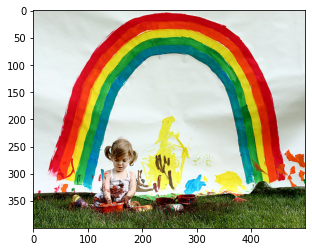

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

In [14]:
pic = '1002674143_1b742ab4b8.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1002674143_1b742ab4b8']

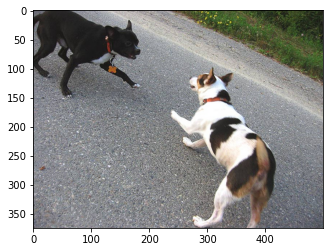

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [15]:
pic = '1001773457_577c3a7d70.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1001773457_577c3a7d70']

# ResNet

In [16]:
incept_model = ResNet50(include_top=True)
# take the 2nd last layer 
last = incept_model.layers[-2].output
cnn_model = Model(inputs = incept_model.input,outputs = last)
cnn_model.summary()

102973440/102967424 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [17]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
__________________________________________________________________________________________________


Let's give our images to the model.The model will give us the 2048 sized vector as an ouput

In [18]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = cnn_model.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
        
    if count > 1299 :
        break
    elif count % 500 == 0:
        print(count)

500
1000


In [19]:
len(images_features)

1300

In [20]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [21]:
take(2, images_features.items())

[('3446191973_1db572ed8a.jpg',
  array([0.12392108, 2.0095015 , 0.        , ..., 0.3821088 , 0.07031471,
         0.31748942], dtype=float32)),
 ('1808504612_3508f3c9bb.jpg',
  array([1.0081412 , 0.3858565 , 0.6827324 , ..., 0.03410221, 0.00393942,
         0.        ], dtype=float32))]

# Text Preprocessing


In [22]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [23]:
captions[:2]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .']

In [24]:
len(captions)

40461

In [25]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
            else:
                captions_dict[img_name].append(caption)
    except:
        pass

In [26]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified

In [27]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

In [28]:
take(2, captions_dict.items())

[('1022454428_b6b660a67b.jpg',
  ['startofseq a couple and an infant , being held by the male , sitting next to a pond with a near by stroller . endofseq',
   'startofseq a couple sit on the grass with a baby and stroller . endofseq',
   'startofseq a couple with their newborn baby sitting under a tree facing a lake . endofseq',
   'startofseq a man and woman care for an infant along the side of a body of water . endofseq',
   'startofseq couple with a baby sit outdoors next to their stroller . endofseq']),
 ('1024138940_f1fefbdce1.jpg',
  ['startofseq two different breeds of brown and white dogs play on the beach . endofseq',
   'startofseq two dogs are making a turn on a soft sand beach . endofseq',
   'startofseq two dogs playing in the sand at the beach . endofseq',
   'startofseq two dogs playing together on a beach . endofseq',
   'startofseq two large tan dogs play along a sandy beach . endofseq'])]

# Create Vocabulary

In [29]:
count_words = {}
count = 1
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:
                count_words[word] = count
                count += 1

In [30]:
len(count_words)

3792

In [31]:
take(10, count_words.items())

[('startofseq', 1),
 ('a', 2),
 ('couple', 3),
 ('and', 4),
 ('an', 5),
 ('infant', 6),
 (',', 7),
 ('being', 8),
 ('held', 9),
 ('by', 10)]

In [32]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():  
            encoded.append(count_words[word])

        captions_dict[k][vv.index(v)] = encoded

In [33]:
take(2, captions_dict.items())

[('1022454428_b6b660a67b.jpg',
  [[1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    7,
    13,
    14,
    15,
    2,
    16,
    17,
    2,
    18,
    10,
    19,
    20,
    21],
   [1, 2, 3, 22, 23, 11, 24, 17, 2, 25, 4, 19, 20, 21],
   [1, 2, 3, 17, 26, 27, 25, 13, 28, 2, 29, 30, 2, 31, 20, 21],
   [1, 2, 32, 4, 33, 34, 35, 5, 6, 36, 11, 37, 38, 2, 39, 38, 40, 20, 21],
   [1, 3, 17, 2, 25, 22, 41, 14, 15, 26, 19, 20, 21]]),
 ('1024138940_f1fefbdce1.jpg',
  [[1, 42, 43, 44, 38, 45, 4, 46, 47, 48, 23, 11, 49, 20, 21],
   [1, 42, 47, 50, 51, 2, 52, 23, 2, 53, 54, 49, 20, 21],
   [1, 42, 47, 55, 56, 11, 54, 57, 11, 49, 20, 21],
   [1, 42, 47, 55, 58, 23, 2, 49, 20, 21],
   [1, 42, 59, 60, 47, 48, 36, 2, 61, 49, 20, 21]])]

In [34]:
from cv2 import cvtColor

In [35]:
MAX_LEN = 0
for k,vv in captions_dict.items():
    for v in vv:
        if len(v)>MAX_LEN:
            MAX_LEN = len(v)     

In [36]:
MAX_LEN

34

In [37]:
VOCAB_SIZE = len(count_words)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE+1)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out

In [38]:
X, y_in, y_out = generator(images_features, captions_dict)

In [39]:
len(X), len(y_in), len(y_out)

(82920, 82920, 82920)

In [40]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

In [41]:
X.shape, y_in.shape, y_out.shape

((82920, 2048), (82920, 34), (82920, 3793))

In [42]:
X[1510]

array([0.4368921 , 0.67115855, 0.11452122, ..., 0.37928808, 0.3331326 ,
       0.1014927 ], dtype=float32)

In [43]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(count_words)+1

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 34, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 128)           485504    
_________________________________________________________________
lstm (LSTM)                  (None, 34, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 34, 128)           32896     
Total params: 912,640
Traina

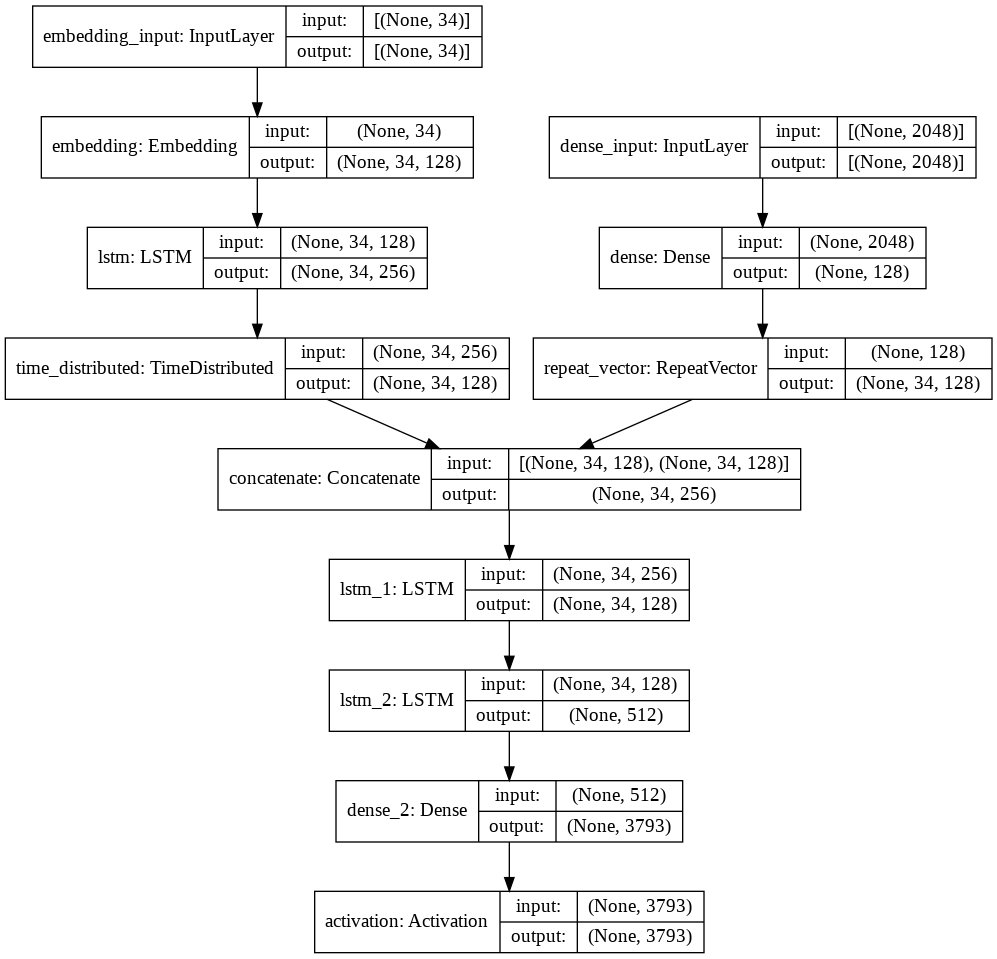

In [44]:
plot_model(model,show_shapes=True)

In [45]:
model.fit([X, y_in], y_out, batch_size=512, epochs=2)

Epoch 1/2
162/162 [==============================] - 31s 82ms/step - loss: 5.4811 - accuracy: 0.1176
Epoch 2/2
162/162 [==============================] - 13s 83ms/step - loss: 4.9086 - accuracy: 0.1887


In [46]:
model.save('model.h5')
model.save_weights('mine_model_weights.h5')
np.save('vocab.npy', count_words)

In [47]:
inv_dict = {v:k for k, v in count_words.items()}

In [48]:
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

# Predictions

In [91]:
translater = google_translator()

In [95]:
def image_caption(image_no):
    test_feature = cnn_model.predict(getImage(image_no)).reshape(1,2048)
    
    test_img_path = images[image_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(count_words[i])

        encoded = [encoded]
        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(model.predict([test_feature, encoded]))
        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word
            
        if sampled_word == 'endofseq':
            break
        text_inp.append(sampled_word)
        
    print(plt.figure())
    print(plt.axis('off'))
    print(plt.imshow(test_img))
    print(plt.xlabel(caption))
    #print(plt.xlabel(translater.translate(caption,lang_tgt=language)))

    #return caption

Figure(432x288)
(0.0, 1.0, 0.0, 1.0)
AxesImage(54,36;334.8x217.44)
Text(0.5, 0, ' a a a a a a a a a a a a a a a a a a a a . endofseq')


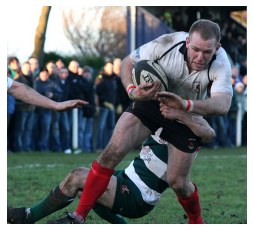

In [97]:
# in hindi
image_caption(20)

# Evaluation

In [117]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(MAX_LEN):
        sequence = [count_words[w] for w in in_text.split() if w in count_words]
        sequence = pad_sequences([sequence], maxlen=MAX_LEN)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = inv_dict[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

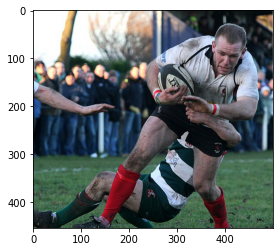

Greedy Search: a a a a a a a a a a a a a a a a a a a a a a a a a . . . endofseq endofseq endofseq endofseq endofseq


In [124]:
image = cnn_model.predict(getImage(20)).reshape(1,2048)
test_img_path = images[20]
x=plt.imread(test_img_path)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))

# Flask

In [125]:
!pip install flask-ngrok

In [126]:
! pip install flask_cors

In [127]:
from flask_ngrok import run_with_ngrok
from flask import Flask

In [128]:
%mkdir static/css -p
%mkdir static/js -p
%mkdir uploads -p
%mkdir templates -p

In [129]:
%%writefile static/js/main.js
$(document).ready(function () {
    // Init
    $('.image-section').hide();
    $('.loader').hide();
    $('#result').hide();

    // Upload Preview
    function readURL(input) {
        if (input.files && input.files[0]) {
            var reader = new FileReader();
            reader.onload = function (e) {
                $('#imagePreview').css('background-image', 'url(' + e.target.result + ')');
                $('#imagePreview').hide();
                $('#imagePreview').fadeIn(650);
            }
            reader.readAsDataURL(input.files[0]);
        }
    }
    $("#imageUpload").change(function () {
        $('.image-section').show();
        $('#btn-predict').show();
        $('#result').text('');
        $('#result').hide();
        readURL(this);
    });

    // Predict
    $('#btn-predict').click(function () {
        var form_data = new FormData($('#upload-file')[0]);

        // Show loading animation
        $(this).hide();
        $('.loader').show();

        // Make prediction by calling api /predict
        $.ajax({
            type: 'POST',
            url: '/predict',
            data: form_data,
            contentType: false,
            cache: false,
            processData: false,
            async: true,
            success: function (data) {
                // Get and display the result
                $('.loader').hide();
                $('#result').fadeIn(600);
                $('#result').text(' Result:  ' + data);
                console.log('Success!');
            },
        });
    });

});

Writing static/js/main.js


In [130]:
%%writefile static/css/main.css
.img-preview {
    width: 200px;
    height: 300px;
    position: relative;
    border: 5px solid #F8F8F8;
    box-shadow: 0px 2px 4px 0px rgba(0, 0, 0, 0.1);
    margin-top: 1em;
    margin-bottom: 1em;
    text-align:center;    
}

.img-preview>div {
    width: 100%;
    height: 100%;
    background-size: 256px 256px;
    background-repeat: no-repeat;
    background-position: center;
    text-align:center;
}

input[type="file"] {
    display: none;
}
.image-section{
    display:flex;
    align-items:center;
    justify-content:center;
}


.loader {
    border: 8px solid #f3f3f3; /* Light grey */
    border-top: 8px solid #3498db; /* Blue */
    border-radius: 50%;
    width: 50px;
    height: 50px;
    animation: spin 1s linear infinite;
}

@keyframes spin {
    0% { transform: rotate(0deg); }
    100% { transform: rotate(360deg); }
}
.language{height:70px;
          width:60%;
           text-align: center;
     background: rgba(255, 255, 255, 0.16);
    box-shadow: 0 8px 32px 0 rgba(31, 38, 135, 0.72);
    backdrop-filter: blur(6.2px);
    -webkit-backdrop-filter: blur(6.2px);
    border-radius: 10px;
    border: 1px solid rgba(255, 255, 255, 0.4);
    transform: translateX(35%);
}


body {
    padding:0px;
    margin:0px;
    background-color: black;
}
header{
   width:100%;
   background-color:lightblue;
}
h1{
    padding:20px;
    text-align:center;
    color: #123F33;
    letter-spacing: 2px;
    animation-name: head;
    animation-duration: 2s;
}
h1:first-letter{
    color:orange;
    border-bottom: 2px solid orange;
}
@keyframes head{
    0%{transform: translateX(500px);}
    50%{letter-spacing: 4px;}
    100%{transform: translateX(0px);}
}
.container{
height:600px;
width:60%;
text-align:center;
transform:translate(0%, 0px);
    -webkit-transform:translate(0%, 0px);
    color:white;
    background: rgba(255, 255, 255, 0.11);
    box-shadow: 0 8px 32px 0 rgba(31, 38, 135, 1);
    backdrop-filter: blur(6.6px);
    -webkit-backdrop-filter: blur(6.6px);
    border-radius: 10px;
    border: 1px solid rgba(255, 255, 255, 0.2)
    
}
 
 
 .button{transform:translateX(0%)
translateY(15%);}


.button {justify-content:center;
      width: 40%;
      text-transform: uppercase;
      font-weight: bold;
      padding:1rem 1rem;
      color:#EFE9F4 ;
      background: #16BAC5;
      outline: none;
      border: 2px solid #EFE9F4;
      transition: .5s all ease-in-out;
      position: relative;
      z-index: 1;
      overflow: hidden;
      text-align:center;
       }
     
.button:after {
        content: '';
        position: absolute;
        top: 50%;
        left: 50%;
        width: 200%;
        height: 0;
        background: #EFE9F4;
        z-index: -1;
        transform: translate(-50%, -50%) rotate(45deg);
        transition: .5s all ease-in-out;
        opacity: 0; }
    
.button:hover {
        color: #16BAC5; }
     
.button:hover.five:after {
          height: 243%;
          opacity: 1; }
          
          
.button:active.five:after {
        height: 400%;
        opacity: 1; } 
          
.shape1{
    height: 200px;
    width: 200px;
    position: absolute;
    background: -o-linear-gradient(
        315deg,
        #FF5B84,
        #EB3461
    );
    background: linear-gradient(
        135deg,
        #FF5B84,
        #EB3461
    );
    border-radius: 50%;
    bottom: 40px;
    right: 150px;
    z-index: -1;
}
.shape2{
    height: 200px;
    width: 200px;
    position: absolute;
    background: -o-linear-gradient(
        315deg,
        #426cf8,
        #3ebdf0
    );
    background: linear-gradient(
        135deg,
        #426cf8,
        #3ebdf0
    );
    border-radius: 50%;
    top: 80px;
    left: 150px;
    z-index: -1;
}

Writing static/css/main.css


In [131]:
%%writefile templates/index.html
{% extends "base.html" %} {% block content %}
<header>
<h1>Image Captioning</h1>
</header>

<div class="shape1"></div>
<div class="shape2"></div>
<br>
<div class="container">
<br/>
    <form id="upload-file" method="post" enctype="multipart/form-data">
        <label for="imageUpload" class="button five">
            Choose...
        </label>
        <br/>
        <input type="file" name="file" id="imageUpload" accept=".png, .jpg, .jpeg">
        <br>
        <div class="language">
           <center><h2>Language</h2></center>
                <select class="language-option" name="Language" style="height:40px; width:30%; background-color:#2d7aed; border-radius:20px; transform: translateX(-10%);" >
                    <option value="hi">Hindi</option>
                    <option value="en">English</option>
                    <option value="fr">French</option>
                    <option value="el">Greek</option>
                    <option value="de">German</option>
                    <option value="it">Italian</option>
                    <option value="ja">Japanese</option>
                    <option value="ur">Urdu</option>
                    <option value="es">Spanish</option>
                    <option value="ru">Russian</option>
                </select>  
        </div>          
    </form>

    <div class="image-section" style="display:none;">
        <div class="img-preview">
            <div id="imagePreview">
            </div>
        </div>
        <div>
            <button type="button" class="btn btn-primary btn-lg " id="btn-predict">Predict!</button>
        </div>
    </div>

    <div class="loader" style="display:none;"></div>

    <h3 id="result" class='readIt'>
        <span> </span>
    </h3>


</div>
<br>
<h4 style="text-align:right; color:white;">Click on the result text for audio</h4>
{% endblock %}

Writing templates/index.html


In [132]:
%%writefile templates/base.html
<html lang="en">

<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <meta http-equiv="X-UA-Compatible" content="ie=edge">
    <title>Image Caption</title>
    <link href="https://cdn.bootcss.com/bootstrap/4.0.0/css/bootstrap.min.css" rel="stylesheet">
    <script src="https://cdn.bootcss.com/popper.js/1.12.9/umd/popper.min.js"></script>
    <script src="https://cdn.bootcss.com/jquery/3.3.1/jquery.min.js"></script>
    <script src="https://cdn.bootcss.com/bootstrap/4.0.0/js/bootstrap.min.js"></script>
    <link href="{{ url_for('static', filename='css/main.css') }}" rel="stylesheet"> 
     {{ read(id='.readIt') }}     
</head>

<body bgcolor="black">
    
 {% block content %}{% endblock %}
</body>

<footer>
    <script src="{{ url_for('static', filename='js/main.js') }}" type="text/javascript"></script>    
</footer>

</html>

Writing templates/base.html


In [133]:
from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class

In [ ]:
!pip install flask_gtts

In [135]:
from flask_gtts import gtts

In [137]:
from flask_gtts import gtts
from flask import Flask, render_template, request
import cv2
from keras.models import load_model
import numpy as np
from tensorflow.keras.applications import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.preprocessing import image, sequence
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import numpy as np


vocab = np.load('vocab.npy', allow_pickle=True)

vocab = vocab.item()

inv_vocab = {v:k for k,v in vocab.items()}


embedding_size = 128
vocab_size = len(vocab)+1
max_len = 37

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))


language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))


conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.load_weights('mine_model_weights.h5')


incept_model = ResNet50(include_top=True)
# take the 2nd last layer 
last = incept_model.layers[-2].output
cnn_model = Model(inputs = incept_model.input,outputs = last)


app = Flask(__name__)
run_with_ngrok(app)
gtts(app)
app.config['SEND_FILE_MAX_AGE_DEFAULT'] = 1


@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['GET', 'POST'])
def upload():
    
    global model, vocab, inv_vocab
    
    if request.method == 'POST':


        img = request.files['file']
        # Save the file to ./uploads
        img.save('uploads/file.jpg')
        lang = request.form['Language']

   
        image = cv2.imread('uploads/file.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224,224))
        image = np.reshape(image, (1,224,224,3))
  
    
        incept = cnn_model.predict(image).reshape(1,2048)

        text_in = ['startofseq']
        result = ''

        count = 0
        while tqdm(count < 20):

            count += 1

            encoded = []
            for i in text_in:
                encoded.append(vocab[i])

            padded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post').reshape(1,max_len)
            sampled_index = np.argmax(model.predict([incept, padded]))
            sampled_word = inv_vocab[sampled_index]

            if sampled_word != 'endofseq':
                result = result + ' ' + sampled_word

            text_in.append(sampled_word)
        
        hi = 0
        en = 0
        fr = 0
        el = 0
        de = 0
        it = 0
        ja = 0
        ur = 0
        es = 0
        ru = 0



        if lang == 'hi':
            hi = 1
            en = 0
            fr = 0
            el = 0
            de = 0
            it = 0
            ja = 0
            ur = 0
            es = 0
            ru = 0
        elif lang=='en':
            hi = 0
            en = 1
            fr = 0
            el = 0
            de = 0
            it = 0
            ja = 0
            ur = 0
            es = 0
            ru = 0  
        elif lang=='fr':
            hi = 0
            en = 0
            fr = 1
            el = 0
            de = 0
            it = 0
            ja = 0
            ur = 0
            es = 0
            ru = 0   
        elif lang=='el':
            hi = 0
            en = 0
            fr = 0
            el = 1
            de = 0
            it = 0
            ja = 0
            ur = 0
            es = 0
            ru = 0 
        elif lang=='de':
            hi = 0
            en = 0
            fr = 0
            el = 0
            de = 1
            it = 0
            ja = 0
            ur = 0
            es = 0
            ru = 0 
        elif lang=='it':
            hi = 0
            en = 0
            fr = 0
            el = 0
            de = 0
            it = 1
            ja = 0
            ur = 0
            es = 0
            ru = 0 
        elif lang=='ja':
            hi = 0
            en = 0
            fr = 0
            el = 0
            de = 0
            it = 0
            ja = 1
            ur = 0
            es = 0
            ru = 0 
        elif lang=='ur':
            hi = 0
            en = 0
            fr = 0
            el = 0
            de = 0
            it = 0
            ja = 0
            ur = 1
            es = 0
            ru = 0 
        elif lang=='es':
            hi = 0
            en = 0
            fr = 0
            el = 0
            de = 0
            it = 0
            ja = 0
            ur = 0
            es = 1
            ru = 0      
        else:
            hi = 0
            en = 0
            fr = 0
            el = 0
            de = 0
            it = 0
            ja = 0
            ur = 0
            es = 0
            ru = 1   



        
        #translater = google_translator()
        #result = translater.translate(result,lang_tgt=lang)
        result = result
                    
        #language='en'
        #speech = gTTS(text = result, lang = language, slow = False)
        #speech.save('uploads/audio.mp3')
        #sound_file = 'uploads/audio.mp3'

        return result
    
    return None


if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://f7c34d7a714a.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [07/Jul/2021 12:00:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 12:00:36] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 12:00:37] "GET /static/css/main.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 12:00:38] "GET /static/js/main.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 12:00:38] "GET /static/css/main.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 12:00:38] "GET /static/js/main.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 12:00:39] "GET /favicon.ico HTTP/1.1" 404 -
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
127.0.0.1 - - [07/Jul/2021 12:01:32] "POST /predict HTTP/1.1" 200 -
